To run this colab you can use your own colab setup or try
[Sandwich Image Compression Lowres Codec](https://colab.research.google.com/github/google/sandwiched_compression/blob/main/sandwich_image_compression_lowres_codec.ipynb).


In [ ]:
!pip install -q mediapy tensorflow-datasets==4.9.4

In [ ]:
!if [ ! -f compress_intra_model.py ]; then \
  git clone https://github.com/google/sandwiched_compression; \
  mv sandwiched_compression/* .; \
fi

In [ ]:
import tensorflow as tf

import mediapy as media
import compress_intra_model
import datasets

In [ ]:
# See https://www.tensorflow.org/datasets for datasets to try.
def dataset_fn(
    batch_size: int, training_mode: bool, take_count: int = 100
) -> tf.data.Dataset:
  return datasets.load_tfds_image_dataset(
      batch_size=batch_size,
      training_mode=training_mode,
      dataset_name='clic',  # insert preferred dataset name.
      target_size=256,
  ).take(
      take_count  # Will draw take_count batches randomly in each epoch.
  )  # Images are 256x256

In [ ]:
# gamma is the Lagrangian multiplier for D + \gamma R loss.
def create_grayscale_codec_model(gamma: float) -> tf.keras.Model:
  return compress_intra_model.create_basic_model(
      model_keys=['image'],
      bottleneck_channels=1,  # grayscale
      output_channels=3,
      num_mlp_layers=2,
      use_jpeg_rate_model=True,
      downsample_factor=1,  # full-res
      num_truncate_bits=0,
      gamma=gamma,
      loop_filter_folder=None,  # Check code to see how to train one separately.
      use_unet_preprocessor=True,
      use_unet_postprocessor=True,
  )

# Only change two parameters for the low-res codec scenario.
def create_lowres_codec_model(gamma: float) -> tf.keras.Model:
  return compress_intra_model.create_basic_model(
      model_keys=['image'],
      bottleneck_channels=3,  # rgb
      output_channels=3,
      num_mlp_layers=2,
      use_jpeg_rate_model=True,
      downsample_factor=2,  # half-res
      num_truncate_bits=0,
      gamma=gamma,
      loop_filter_folder=None,
      use_unet_preprocessor=True,
      use_unet_postprocessor=True,
  )

In [ ]:
train_batch_size = 4
train_dataset = dataset_fn(train_batch_size, True)  # Pull from train split.
eval_batch_size = 1
eval_dataset = dataset_fn(eval_batch_size, False)  # Pull from eval split.

In [ ]:
# Simple trainer. It is recommended to use a custom trainer and train to
# convergence.

num_epochs = 800
gamma = 50  # Lagrange multiplier

base_model = create_lowres_codec_model(gamma)
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

epoch_stat = tf.keras.metrics.Mean()
loss_fn = compress_intra_model.create_basic_loss(gamma=gamma)

for i in range(num_epochs):
  for train_batch in train_dataset:
    with tf.GradientTape() as tape:
      out = base_model(train_batch)
      loss = loss_fn(train_batch, out)

      gradients = tape.gradient(loss, base_model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, base_model.trainable_variables))
      epoch_stat(loss)

  # Note each epoch is over a varying set of take_count x batch_size images.
  # Calculate a median or change the dataset loader to always use the same set
  # if you prefer.
  print(f'Epoch {i:=4d}/{num_epochs:=4d} Loss: {epoch_stat.result():=4.4f}')
  epoch_stat.reset_states()

Epoch    0/ 800 Loss: 2660.7207
Epoch    1/ 800 Loss: 322.0422
Epoch    2/ 800 Loss: 234.4453
Epoch    3/ 800 Loss: 205.9478
Epoch    4/ 800 Loss: 198.3490
Epoch    5/ 800 Loss: 144.9349
Epoch    6/ 800 Loss: 158.7682
Epoch    7/ 800 Loss: 131.9510
Epoch    8/ 800 Loss: 132.8389
Epoch    9/ 800 Loss: 132.8671
Epoch   10/ 800 Loss: 144.4482
Epoch   11/ 800 Loss: 122.8269
Epoch   12/ 800 Loss: 124.9798
Epoch   13/ 800 Loss: 142.7530
Epoch   14/ 800 Loss: 131.4464
Epoch   15/ 800 Loss: 136.6427
Epoch   16/ 800 Loss: 124.9614
Epoch   17/ 800 Loss: 117.5014
Epoch   18/ 800 Loss: 114.5062
Epoch   19/ 800 Loss: 135.6827
Epoch   20/ 800 Loss: 117.8703
Epoch   21/ 800 Loss: 120.8027
Epoch   22/ 800 Loss: 115.1274
Epoch   23/ 800 Loss: 119.2278
Epoch   24/ 800 Loss: 119.7231
Epoch   25/ 800 Loss: 111.6443
Epoch   26/ 800 Loss: 129.5453
Epoch   27/ 800 Loss: 112.7596
Epoch   28/ 800 Loss: 108.7468
Epoch   29/ 800 Loss: 97.5976
Epoch   30/ 800 Loss: 100.5456
Epoch   31/ 800 Loss: 92.0226
Epoch   3


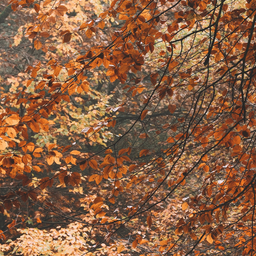
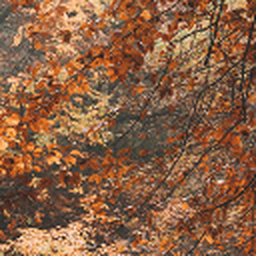
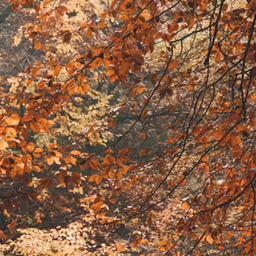
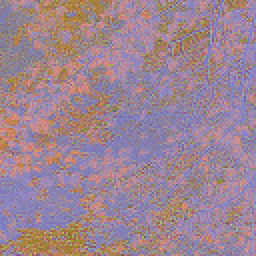


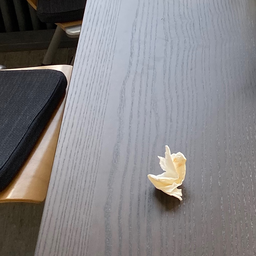
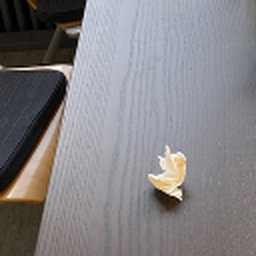
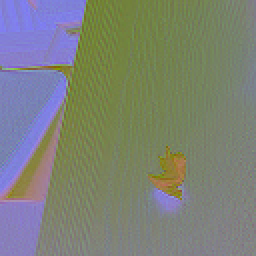


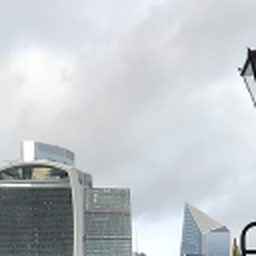
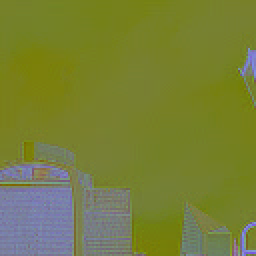


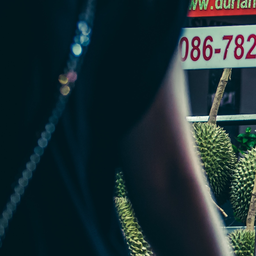
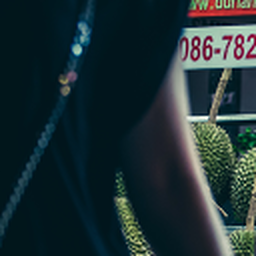
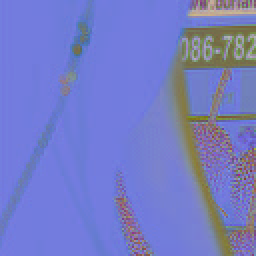


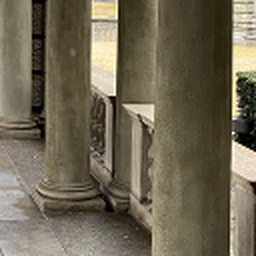
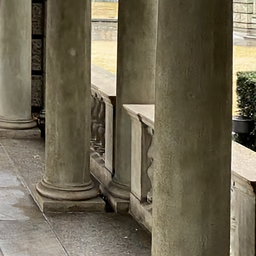
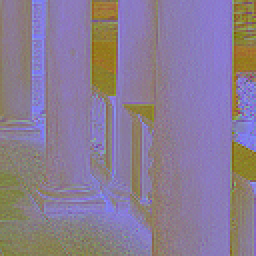


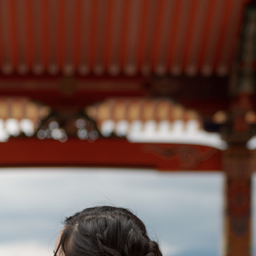
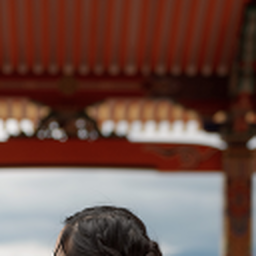
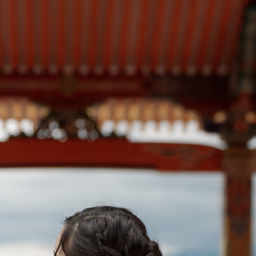


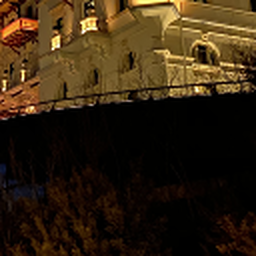
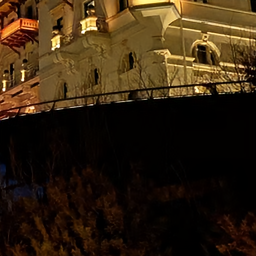


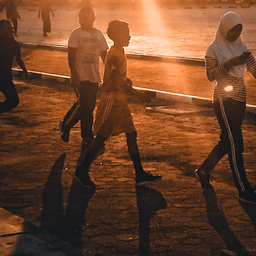
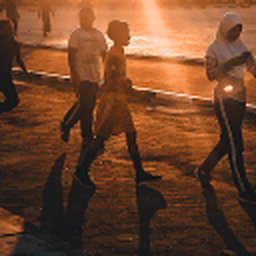
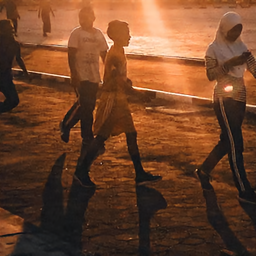
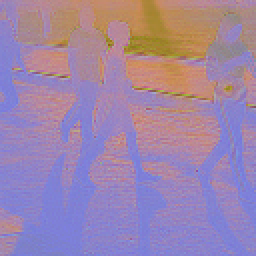


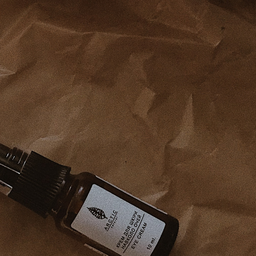
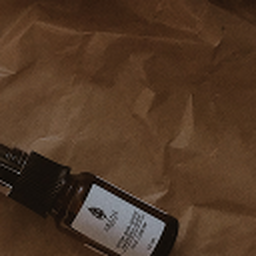
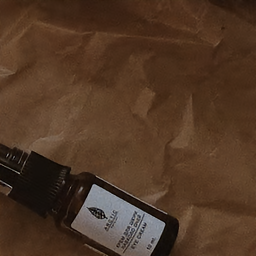
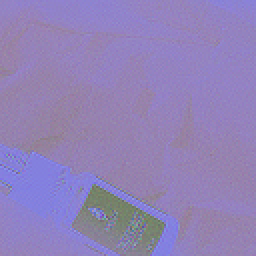


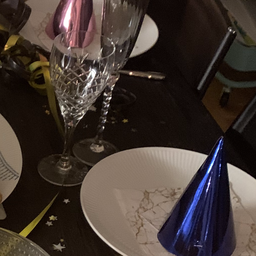
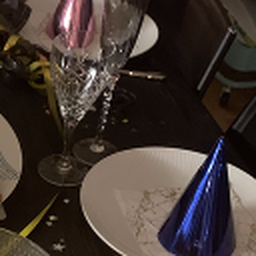
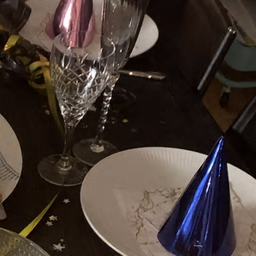
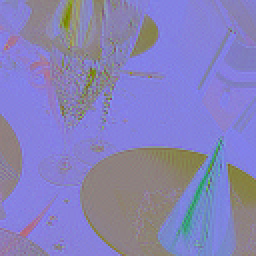

In [ ]:
# It is recommended to generate R-D curves by training multiple models for
# multiple gammas, then evaluate each model for multiple qsteps, and construct
# the Pareto frontier. Please see the paper for details:
# https://arxiv.org/abs/2402.05887

# Discussion on the results shown below:
#
# For the low-res codec scenario pay attention to areas where the simple linear
# has lost detail, e.g., text and textures, has aliasing, e.g., merging
# lines/edges, etc. Notice how much better the model predictions are and also
# notice what compressed-bottlenecks transport in these areas. Running
# post-processing-only models will typically generate wrong results in these
# areas. Please see the paper for examples.
#
# One can design models to hallucinate detail but it is important to understand
# that hallucination is not accurate transport. When one watches a movie one
# wants to see it as the director, cinematographer, etc., have intended it. One
# does not want to see some model's hallucinated reinterpretation of the
# art/reality.

def simple_linear_path(sample: tf.Tensor) -> tf.Tensor:
  factor = base_model.downsample_factor
  low_res = tf.image.resize(
      sample,
      size=[sample.shape[0] // factor, sample.shape[1] // factor],
      method=tf.image.ResizeMethod.BICUBIC,
  )
  return tf.image.resize(
      low_res,
      size=[sample.shape[0], sample.shape[1]],
      method=tf.image.ResizeMethod.LANCZOS3,
  )


# Pictures to show. Can also look at the proxy rate through 'rate', calculate
# distortion or whatever else you would like.
show_keys = ['prediction', 'compressed_bottleneck']
show_count = 10

# Upsample the bottlenecks using nearest neighor for clarity.
upsample_keys = ['compressed_bottleneck']

for idx, sample in enumerate(eval_dataset.as_numpy_iterator()):
  if idx >= show_count:
    break

  # Path 1: Simple demo:
  # Run the pre-processor, codec-proxy, and the post-procesor.
  output = base_model(sample)

  # Path 2: Actual performance with your codec:
  # Run the pre-processor, your codec, then post-processor.
  #
  # bottlenecks = base_model.run_preprocessor(sample, training=False)
  # compressed_bottlenecks = insert_your_image_codec_binary(bottlenecks)
  # output = {
  #     'bottleneck': bottlenecks,
  #     'compressed_bottleneck': compressed_bottlenecks,
  #     'prediction': base_model.run_postprocessor(
  #         compressed_bottlenecks, training=False
  #     ),
  # }

  images = {'original': sample['image'][0] / 255}

  # Emulate linear up-down without compression.
  images['simple_linear'] = simple_linear_path(images['original'])

  images.update(
      {key: value[0] / 255 for key, value in output.items() if key in show_keys}
  )
  for key in upsample_keys:
    images[key] = tf.image.resize(
        images[key],
        size=[sample['image'].shape[1], sample['image'].shape[2]],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    ).numpy()
  media.show_images(images, height=512)